# Trabalho prático 2 - Realidade Aumentada
Vinicius Julião Ramos - 2018054630


Neste trabalho foi desenvolvido uma aplicação de realidade aumentada. A entrada do trabalho consite em três diferentes entidades, sendo elas:

1. Informação de calibração da câmera.
2. Um vídeo, no qual será projetado um objeto 3D do personagem Pikachu.
3. Uma imagem alvo, que será identificada no vídeo, para posicionamento da projeção do personagem Pikachu.

A estrutura deste trabalho foi construída em formato de um *pipeline* para que em cada *frame* do vídeo (1) colete-se a posição de cada imagem alvo, (2) calcule-se o posicionamento em 3 dimensões da imagem alvo, em relação à câmera e (3) exiba-se a imagem do Pikachu sobre os alvos, de maneira que o posicionamento em 3 dimensões do personagem, corresponda à cena daquele frame em questão. Portanto, a seguir, cada uma das etapas neccessárias nesse pipeline serão explicadas. Todas as bibliotecas utilizadas para a implementação desse trabalho são mostradas a seguir:

In [1]:
import cv2
import numpy as np
import pygame
import matplotlib.pyplot as plt
from OpenGL.GL import *
from PIL import Image
from OpenGL.GLUT import *
from OpenGL.GLU import *
from objloader import * # arquivo fornecido pelo professor

print("OpenGL:", OpenGL.__version__)
print("OpenCV:", cv2.__version__)
print("PIL:", Image.__version__)
print("pygame:",pygame.__version__)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
OpenGL: 3.1.5
OpenCV: 4.4.0
PIL: 7.2.0
pygame: 1.9.6


## Passo 1 - Obtenção dos parâmetros intrissecos da câmera.

Apesar dos dados já estarem discriminados abaixo, os parâmetros intríssecos foram obtidos através do software Octave, versão 5.2, em conjunto com a biblioteca de calibração de câmera, disponiblizada em: [https://github.com/nghiaho12/camera_calibration_toolbox_octave](https://github.com/nghiaho12/camera_calibration_toolbox_octave). Para tal calibração, utilizou-se de 15 *frames* distintos do vídeo fornecido junto com a descrição do trabalho.

In [2]:
intrMat = np.float32([[416.7308, 0, 320.309], [0, 414.2021, 221.29132], [0, 0, 1]])
distVec = np.float32([0.08244, -0.0107, -0.00742, -0.011, 0.00000])

## Passo 2 - Detecção dos alvos e respectivas posições.

Apesar da estrutura geral deste trabalho consistir em um *pipeline*, optou-se por modularizar o código em pequenas funções, a fim de que distinguir os objetivos de cada etapa de tratamento da imagem. As saídas dos blocos de código a seguir foram extraídas do primeiro *frame* do vídeo fornecido juntamente com a descrição desse trabalho.

In [3]:
cap = cv2.VideoCapture('entrada.mp4')
ret, frame = cap.read()
cap.release()

As funções a seguir, auxiliam na remoção de ruídos do frame do vídeo. Como o alvo trata-se de uma imagem em preto e branco, elimina-se as informações desnecessárias (ruídos) como as cores do *frame* recebido como parâmetro das funções. Essa eliminação é feita em dois níveis diferentes, cada uma com a respectiva função:

* `getBinarizedImage(image)`: Recebe uma imagem colorida em RGB como entrada e retorna uma imagem com *pixels* binários. Para isso primeiro converte-se a imagem de colorido para a escala de cinza. Após a conversão em escala de cinza, transforma-se a imagem para binário de modo que é possível parametrizar o intervalo em escala de cinza no qual a chamada à `cv2.threshould` converterá cada pixel para branco ou preto.
* `getEdgedImage(binarizedImage)`: Como o alvo trata-se de uma imagem quadrada, utilizamos a conversão da imagem binarizada recebida na entrada, para produzir como saída uma imagem que destaque as bordas da imagem. Ou seja, sempre que a imagem houver uma transição entre bits vizinhos de branco para preto (ou vice e versa) haverá a formação de uma aresta. Sendo assim, nosso identificador do alvo terá mais facilidade em identificar os possíveis alvos.

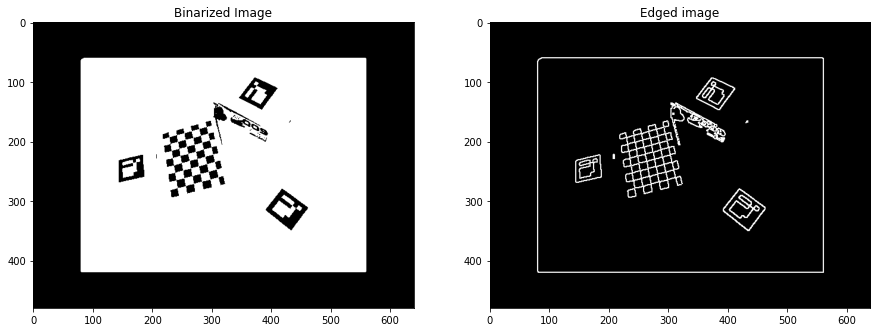

In [4]:
def getBinarizedImage(image):
    # to gray scale
    processedImg = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # binarize image
    _, processedImg = cv2.threshold(processedImg, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return processedImg


def getEdgedImage(binarizedImage):
    # image canny detection
    edgedImg = cv2.Canny(binarizedImage, 100, 200)
    kernel = np.ones((2, 2))
    edgedImg = cv2.dilate(edgedImg, kernel, iterations=1)
    return edgedImg

binImage = getBinarizedImage(frame)
edgedImage = getEdgedImage(binImage)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Binarized Image")
plt.imshow(binImage, cmap='gray')
bx = fig.add_subplot(1, 2, 2)
bx.set_title("Edged image")
plt.imshow(edgedImage, cmap='gray')
plt.show()


A partir de uma imagem binarizada ou então até mesmo uma imagem de bordas, a função a seguir é responsável por buscar os possíveis alvos no frame. Observe que neste ponto, ainda não há nenhum tipo de *matching* com o nosso alvo, apenas a identificação de polígonos, dadas as bordas dos objetos identificados numa imagem binarizada ou numa imagem de bordas.

* `getCandidateContours(edgedImg)`: recebe como parâmetro uma imagem de bordas ou então uma imagem binarizada, e retorna todos os contornos de com apenas 4 vértices (*corners*). Além disso, há um tratamento de identificação desses possíveis alvos, de maneira que só serão considerados aqueles que estão dentro de um intervalo da área mínima ou máxima do polígono. Também o contorno deve ser convexo, pois as possíveis transforações sofridas por um retêngulo projetado em 3D não farão surgir um plano em que se forme concavidades.

Assim, a imagem mostrada a seguir, demonstra os contornos candidatos a alvos. Neste caso, coincidentemente houve uma correnspondência com todos os alvos exibidos no *frame*. Entretanto, caso o limite de áre fosse relaxado, permitindo identificar retangulos maiores, o tabuleiro de xadres também surgiria como um candidato. Por isso, é necessário um certificado de *matching* do alvo, que será dado posteriormente.

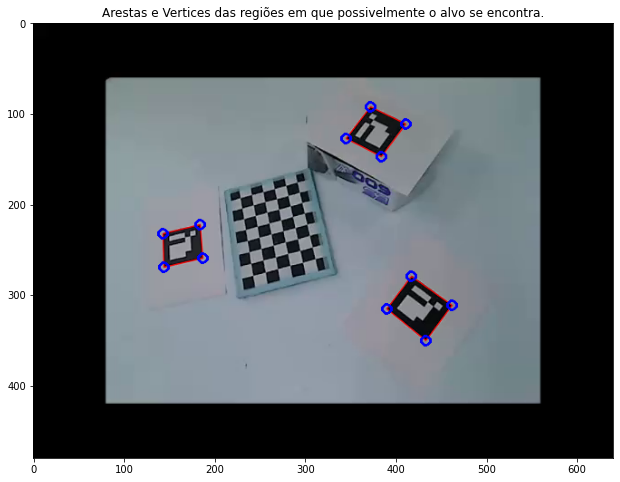

In [5]:
def getCandidateContours(edgedImg):
    
    contours, hierarchy = cv2.findContours(edgedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    image_height, image_width = edgedImg.shape
    candidate_countours = []
    # The area of interest are those ones that fits at most 50% and at least 0.1% of the whole image
    maxArea = image_height*image_width*0.5
    minArea = image_height*image_width*0.001
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < maxArea and area > minArea:
            perimeter = cv2.arcLength(cnt, True)
            approx_polygon = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)
            if (cv2.isContourConvex(approx_polygon) and len(approx_polygon) == 4):
                candidate_countours.append(approx_polygon)
                
    return candidate_countours


# contours = getCandidateContours(edgedImage)
contours = getCandidateContours(binImage)
image = frame.copy()
image = cv2.drawContours(image=image, contours=contours, contourIdx=-1,
                         color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
for cont in contours:
    for (i, p) in enumerate(cont):
        image = cv2.circle(image, tuple(p[0]), 5, color=(0, 0, 255), thickness=2)
plt.subplots(figsize=(15,8))
plt.title('Arestas e Vertices das regiões em que possivelmente o alvo se encontra.')
plt.imshow(image)
plt.show()

Neste ponto, incia-se a chamada às funções de *matching* com a imagem alvo, mostrada a seguir. Uma vez que as regiões, em que os alvos podem se encontrar, são dadas pela chamada à função `getCandidateContours`, basta que utilizemos uma métrica para a comparação da região obtida, com o alvo em questão. O alvo original é mostrado a seguir, já com a conversão em modo binário, pois será esta que utilizaremos para comparar a qualidade do matching com a imagem.

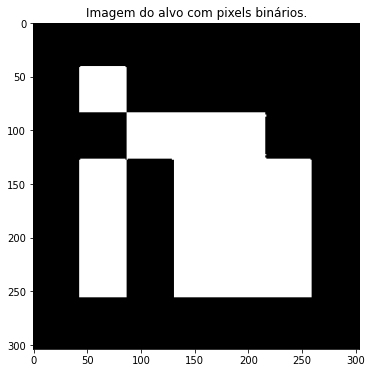

In [6]:
targetImg = cv2.imread("alvo.jpg")
binTargetImg = getBinarizedImage(targetImg)
edgedTargetImg = getEdgedImage(binTargetImg)
plt.subplots(figsize=(6,6))
plt.imshow(binTargetImg, cmap='gray')
plt.title('Imagem do alvo com pixels binários.')
plt.show()

Por fim, a detecção dos alvos na imagem da cena (*frame*) é dada em duas etapas. Tomando como exemplo, o caso do primeiro frame do vídeo, em que temos três contornos candidatos ao *mathcing*  do alvo, para cada contorno obtemos a homografia em relação ao alvo. Entretanto, a corresponência dos pontos exigida pela função `cv2.findHomography` é propositalmente feita de maneira que apenas desejamos corresponder vértices (contornos) vizinhos, por exemplo:
  Dado que a imagem é retângular, então temos 4 vérices: Superior-Esquerdo (SE), Superior-Direito (SD), Inferior-Esquerdo (IE) e Inferior-Direito (ID). Na obtenção da homografia nesta implementação, basta que o vetor contendo os pontos de cada vértice do contorno seja ordenado de maneira que um vértice seja vizinho do vértice subsequente na ordem do vetor. Ou seja, estamos correpspondendo os vértices do contorno com os pontos das extremidadaes da imagem alvo. Portanto, após a obtenção da homografia e projetar a imagem aplicada à matriz de homografia, será necessário rotacionar tal projeção, de maneira a encontrar a verdadeira correpondência dos vértices.
* `targetMatching(targetBinImg, sceneBinImg, contour)`: Recebe como entrada a imagem do alvo e a cena (ambos já com pixels binários) e também o contorno ao qual se deseja obter a homografia. Retorna a projeção daquele contorno em 2D após aplicar a perspectiva dada pela matriz.

Observe a seguir que a homografia obtida nos retorna as imagens rotacionadas para os três alvos possivelmente detectados:

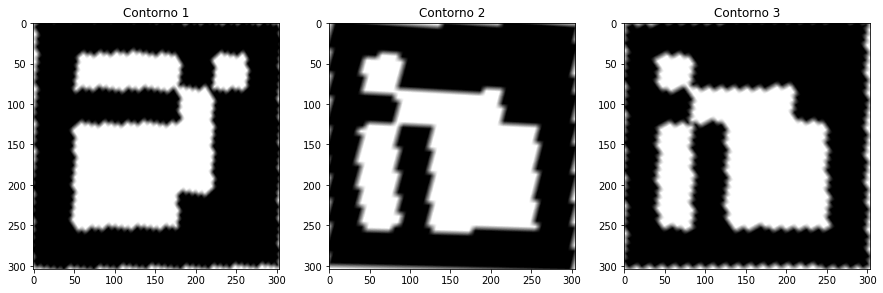

In [7]:
def targetMatching(targetBinImg, sceneBinImg, contour):
    target_height, target_width = targetBinImg.shape
    target_corners = np.array([[0,0],
                               [target_width-1, 0],
                               [target_width-1, target_height-1],
                               [0, target_height-1]])
    homography_matrix, _ = cv2.findHomography(contour, target_corners, cv2.RANSAC, 5.0)
    projection = cv2.warpPerspective(sceneBinImg, homography_matrix, (target_width, target_height), flags=cv2.INTER_LINEAR)
    return projection

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15, 5))
proj1 = targetMatching(binTargetImg, binImage, contours[0])
ax = fig.add_subplot(gs[0,0])
ax.set_title('Contorno 1')
plt.imshow(proj1, cmap='gray')

proj2 = targetMatching(binTargetImg, binImage, contours[1])
bx = fig.add_subplot(gs[0,1])
bx.set_title('Contorno 2')
plt.imshow(proj2, cmap='gray')

proj3 = targetMatching(binTargetImg, binImage, contours[2])
cx = fig.add_subplot(gs[0,2])
cx.set_title('Contorno 3')
plt.imshow(proj3, cmap='gray')
plt.show()

Após a obtenção das projeções, o segundo passo para confimar que o possível contorno foi identificado como um alvo é aplicar uma métrica que será o certificado do *matching*. Para isso, utilizamos o `PSNR` que avalia quão ruidoso um sinal é, comparado a outro sinal. Nesta implementação, aqueles contornos que possuem valores de `PSNR` superiores a `10` quando comparados com a imagem do alvo são considerados um *matching*. Além disso, uma vez que os possíveis alvos podem estar rotacionados, assim como mostra a o contorno candidato numer 1 acima, ainda nessa mesma etapa, rotacionamos o alvo candidato em 90 graus por 4 vezes, para que assim, a pose seja corretamente calculada.
* `getBestRotation(projectionBinImg, targetBinImg)`: recebe como entrada duas imagens com pixels binários, e retorna a quantidade de rotções de 90 graus foram necessárias para o melhor matching segundo a métrica`PSNR`. Se o valor da métrica for inferio a 10 para todas rotações, então retorna um valor -1.

Observe a seguir a quantidade de rotações que foram necessárias para cada uma das imagens do contono acima:

In [8]:
ROTATION_BAD = -1
ROTATION_0 = 0
ROTATION_90 = 1
ROTATION_180 = 2
ROTATION_270 = 3

def getBestRotation(projectionBinImg, targetBinImg):
    proj = projectionBinImg.copy()
    
    max_psnr = (-1,-1)
    for rotation_idx in [ROTATION_0, ROTATION_90, ROTATION_180, ROTATION_270]:
        max_psnr = max(max_psnr, (cv2.PSNR(targetBinImg, proj), rotation_idx))
        proj =  cv2.rotate(proj, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    if(max_psnr[0] > 10): return max_psnr[1]
    return ROTATION_BAD 

matchedContours = []
rotation_val = getBestRotation(proj1, binTargetImg)
if(rotation_val >= 0):
    matchedContours.append((contours[0], rotation_val))
rotation_val = getBestRotation(proj2, binTargetImg)
if(rotation_val >= 0):
    matchedContours.append((contours[1], rotation_val))
rotation_val = getBestRotation(proj3, binTargetImg)
if(rotation_val >= 0):
    matchedContours.append((contours[2], rotation_val))

print("Rotações em 90 graus antihorário para o contorno 1:", matchedContours[0][1])
print("Rotações em 90 graus antihorário para o contorno 2:", matchedContours[1][1])
print("Rotações em 90 graus antihorário para o contorno 3:", matchedContours[2][1])

Rotações em 90 graus antihorário para o contorno 1: 1
Rotações em 90 graus antihorário para o contorno 2: 0
Rotações em 90 graus antihorário para o contorno 3: 0


Então, podemos plotar os alvos identificados na cena, e os contornos correspondentes:

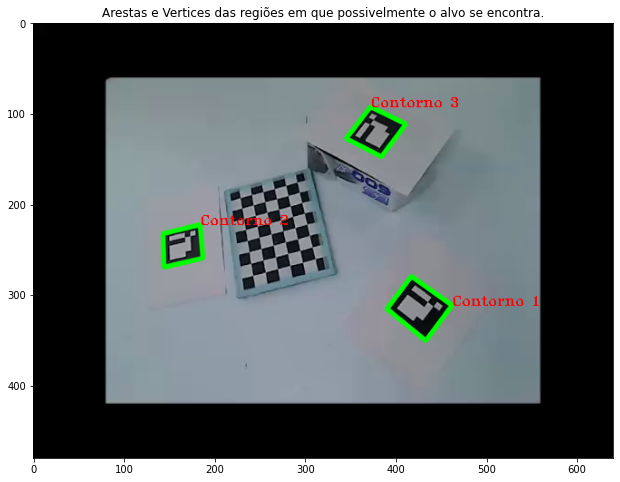

In [9]:
image = frame.copy()
image = cv2.drawContours(image=image, contours=contours, contourIdx=-1,
                         color=(0, 255, 0), thickness=3, lineType=cv2.LINE_AA)

for idx, cont in enumerate(matchedContours):
    cv2.putText(img=image,
                text='Contorno {}'.format(idx+1), 
                org=tuple(cont[0][cont[1]][0]),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                fontScale=0.5, color=(255, 0, 0),
                thickness=1)
    
plt.subplots(figsize=(15,8))
plt.title('Arestas e Vertices das regiões em que possivelmente o alvo se encontra.')
plt.imshow(image)
plt.show()

## Passo 3 - Estimação da pose

Uma vez que já conhecemos a rotação necessária para a correspondencia de pontos na etapa da homografia, é possível obter a matriz de parâmetros extrínsecos aplicando a rotação à base 3d utilizada para o calculo dos parâmetros extrínssecos. A linha 2 do coódigo abaixo, contém a base 3d que é rotacionada de acordo com o retorno da função `getBestRotation`. Assim, a chamada de `cv2.solvePnP` nos dará como retorno a matriz de rotação e a matriz de translação (que são parte da matriz de parâmetros extrínsecos.

Então, utilizando as duas matrizes do retorno de `getPose` calcularemos a matriz de perspectiva, que posteriomente será passada para projetar os objetos em 3d. Sendo assim, as duas funções abaixo são responsáveis por:
* `getPose(matchedContour, rotation_shif)`: Recebe como entrada o contorno que foi identidicado como alvo, e a quantidade de rotações em 90 graus, antihorário, necessária para o alinhamento dos cantos. Calcula a matriz de parametros extrínsecos retornando a matriz de rotação e translação.

* `getPerpectiveMatrix(rotarionMat, translationMat)`: Recebe como parêmtro as matrizes de rotação e tranlação calculadas na obtenção da pose do alvo. Retorna a matriz de perspectiva.


In [10]:
def getPose(matchedContour, rotation=ROTATION_0):
    base3D = [[0,0,0], [1,0,0], [1,-1,0], [0,-1,0]]
    base_matrix_shift = rotation if rotation != ROTATION_90 else -rotation
    rotated3DBase = np.array(base3D[base_matrix_shift:]+base3D[:base_matrix_shift], dtype=np.float64)
    _, rotation, translation = cv2.solvePnP(rotated3DBase, matchedContour.astype(float), intrMat, distVec)
    return rotation, translation

def getPerspectiveMatrix(rotationMat, translationMat):
    rodr, _ = cv2.Rodrigues(rotationMat)
    perpectiveMat = np.append(rodr, translationMat, axis=1)
    perpectiveMat = np.append(perpectiveMat, [[0, 0, 0, 1]], axis=0)
    perpectiveMat[1:3, 0:4] *= -1
    return np.transpose(perpectiveMat).astype('float64')

In [11]:
# TODO: DELETAR ESSE BLOCO

# https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html
def draw(img, corner, projection):
    corner = tuple(corner.astype(int).ravel())
    img = cv2.line(img, corner, tuple(projection[0].astype(int).ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(projection[1].astype(int).ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(projection[2].astype(int).ravel()), (0,0,255), 5)
    return img

#https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html
def draw_poses(sceneImg, rotation, contour, pose):
    image = sceneImg.copy()
    axis = np.float32([[1,0,0], [0,1,0], [0,0,1]])
    gray = cv2.cvtColor(sceneImg,cv2.COLOR_BGR2GRAY)
    proj, jacob = cv2.projectPoints(axis, pose[0], pose[1], intrMat, distVec)
    image = draw(image, contour[rotation], proj)
    plt.imshow(image, cmap='gray'),
    plt.title("pose")
    plt.show()

# targetBinImg = getBinarizedImage(targetImg)
# sceneBinImg = getBinarizedImage(frame)
# rotationIdx = targetMatching(targetBinImg, sceneBinImg, contours[0])
# pose = getPose(contours[0], rotation=rotationIdx)
# print(rotationIdx)
# print(getPerspectiveMatrix(pose[0], pose[1]))
# draw_poses(frame, rotationIdx, contours[0], pose)

# rotationIdx = targetMatching(targetBinImg, sceneBinImg, contours[1])
# pose = getPose(contours[1], rotation=rotationIdx)
# print(rotationIdx)
# draw_poses(frame, rotationIdx, contours[1], pose)

# rotationIdx = targetMatching(targetBinImg, sceneBinImg, contours[2])
# pose = getPose(contours[2], rotation=rotationIdx)
# print(rotationIdx)
# draw_poses(frame, rotationIdx, contours[2], pose)

## Passo 4 e 5 - Rendereização dos objetos e rotação do Pikachu
Para estes dois ultimos passos, é necessário a chamada de rotinas auxiliares, que incluem o ajuste de perspectiva da imagem, a inicialização do ambiente, e a rederização da imagem do fundo. As funções responsáveis por tais rotinas são:
* `cameraAdjusts(width, height)`: Recebe como entrada a largura e altura da imagem da cena. A partir desses valores e do uso da matriz de parâmetros intríssecos, ajusta a perspectiva pela chamada à `gluPerspective`.
* `initOpenGL(dimensions)`: Recebe como entrada a largura e altura da imagem da cena. Inicializa o ambiente do OpenGL
* `background(backgroundImg)`: Recebe a imagem da cena, que será projetada como o fundo da imagem pelo OpenGL. 
* `idleCallback()`: Define as chamadas que são realizadas quando o status do OpenGL está em `idle`.

In [12]:
def cameraAdjusts(dimensions):
    width, height = dimensions
    fx = intrMat[0, 0]
    fy = intrMat[1, 1]
    fovy = 2 * np.arctan(0.5 * height / fy) * 180 / np.pi
    aspect = width * fy / (height * fx)
    gluPerspective(fovy, aspect, 0.1, 100.0)


def initOpenGL(dimensions):
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)
    glEnable(GL_DEPTH_TEST)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    

def background(backgroundImg):
    w, h = (640, 480)
    x, y = (0, 0)
    glBindTexture(GL_TEXTURE_2D, glGenTextures(1))
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, w, h, 0, GL_BGR, GL_UNSIGNED_BYTE, backgroundImg)

    glDepthMask(GL_FALSE)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    glOrtho(0, w, h, 0.0, 0.0, 1)
    
    glEnable(GL_TEXTURE_2D)
    glBegin(GL_QUADS)
    
    for i, j in [(0, 0), (1, 0), (1, 1), (0, 1)]:
        glTexCoord2f(i, j)
        glVertex2f(x + w * i, y + h * j)

    glEnd()

    glBindTexture(GL_TEXTURE_2D, 0)
    glDepthMask(GL_TRUE)

def idleCallback():
    glutPostRedisplay()


A função abaixo é responsável pela chamada às funções de renderização da bilbioteca OpenGL. Nela há três diferentes renderizações:
1. O cubo.
2. O indicador de direção (por meio de um cone).
3. O personagem Pikachu.

Como a matriz de parêmtros instíssecos foi calculada manualmente, houve a necessidade de ajustar a translação dos objetos, de forma a posicioná-los melhor sobre o alvo identificado. O posicionamento dos objetos 3d é dado pela matriz de projeção (`viewMatrix`) que obtida no retorno da função `getPerspectiveMatrix`. Assim, a partir da chamada a `glLoadMatrixf(viewMatrix)` o objeto é posicionado sobre o alvo, necessitando apenas alguns ajustes.

Outros ajustes também foram necessários para que o cone projetado se comporte como um indicador de direção, como solicitado no trabalho.

Por fim, como foi solicitado que a cada frame o Pikachu rotacione, a função `object3D` recebe o angulo que apenas o Pikachu será rotacionado naquela chamada.
* `object3D(viewMatrix, rotationAngle)`: Recebe como entrada a matriz de perspectiva e a rotação aplicada ao pikachu em determinado *frame* do vídeo. Projeta três objetos 3d na cena: Um cubo, um indicador de direção e um Pikachu.

In [13]:
def object3D(viewMatrix, rotationAngle):
    global pikachu_obj
    glPushMatrix()
    glLoadMatrixf(viewMatrix)
    

    glPushMatrix()
    glTranslatef(.5, .5, .25)
    glRotate(-90, 1, 0, 0)
    glutWireCone(.2,.8, 10, 6)
    glPopMatrix()
    
    glTranslatef(.2, -.25, 0)
    # renderiza um cubo
    glutWireCube(1.5)
    # renderiza o modelo do Pikachu
    glPushMatrix()
    glScalef(.4, .4, .4)
    glRotate(-rotationAngle, 0, 0, 1)
    glCallList(pikachu_obj.gl_list)
    glPopMatrix()
    glPopMatrix()

Por fim, a função `displayCallback()` é resposável pela chamada à todo pipeline que fora mostrado acima. Para a execução das chamadas à `displayCallback`, é necessário manter referências a instancias globais:
* Carregamento do Vídeo
* Carregamento da Imagem alvo
* Ângulo de rotação do frame atual
* Objeto carregado do personagem Picachu

Dentre as decisões tomadas, aquelas que se destacam são:
* A cada frame, a imagem do pikachu será rotacionada em 1 grau.
* A fim de que a reprodução tenha concordância com o tempo do vídeo, ao final de cada chamada à `displayCallback` aplica-se um sleep de $\frac{1}{30}$ segundos.


In [14]:
global pikachu_obj
pikachu_obj = None

global videoCap
videoCap = cv2.VideoCapture('entrada.mp4')

ret, frame = cap.read()
cap.release()

targetImg = cv2.imread("alvo.jpg")
global targetBinImg
targetBinImg= getBinarizedImage(targetImg)

global rotation_angle
rotation_angle = 0

import time
def displayCallback():
    global videoCap, targetBinImg, rotation_angle, pikachu_obj
    
    # Captura o angulo de rotação do pikachu em um dado frame
    rotation_angle = rotation_angle%360
    
    # Caso o vídeo tenha se encerrado, retoma ao início
    ret, frame = videoCap.read()
    if not ret:
        videoCap.set(2,0)
        ret, frame = videoCap.read()
    
    # Execução do pipeline que utiliza o OpenCV
    sceneBinImg = getBinarizedImage(frame)
    extrissecMatrixes = []
    contours = getCandidateContours(sceneBinImg)
    for cnt in contours:
        projection = targetMatching(targetBinImg, sceneBinImg, cnt)
        rotationIdx = getBestRotation(projection, targetBinImg)
        if rotationIdx < 0: continue
        pose = getPose(cnt, rotationIdx)
        extrissecMatrixes.append(getPerspectiveMatrix(pose[0], pose[1]))
    
    
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    
    # Renderização do background
    background(frame)
    
    # carregar o modelo 3D do Pikachu, apenas se não estiver carregado
    if pikachu_obj is None:
        pikachu_obj = OBJ("Pikachu.obj", swapyz=True)
    
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity() 
    cameraAdjusts((640, 480))
    
    # habilita o uso de texturas (o Pikachu tem textura)
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glEnable(GL_TEXTURE_2D)
    for mat in extrissecMatrixes:
        object3D(mat, rotation_angle)
    
    # A cada frame, rotaciona 1 grau a mais.
    rotation_angle += 1
    
    # Ajusta o tempo de reprodução do vídeo
    time.sleep(1 / 30)
    glutSwapBuffers()


In [15]:
def start():
    global videoCap
    dimensions = (640, 480)
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
    glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
    glutInitWindowSize(*dimensions)
    window = glutCreateWindow(b'Pikachu - Realidade Aumentada')
    initOpenGL(dimensions)
    
    
    glutDisplayFunc(displayCallback)
    glutIdleFunc(idleCallback)
    
    glutMainLoop()
    videoCap.release()


In [16]:
start()